In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 
from mlrefined_libraries import superlearn_library as superlearn

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

In [176]:
import time
from IPython.display import clear_output

# function for assigning each point in a dataset to one of K folds
def assign_to_folds(L,K):
    # split data into k equal (as possible) sized sets
    order = np.random.permutation(L)
    c = np.ones((L,1))
    L = int(np.round((1/K)*L))
    for s in np.arange(0,K-2):
        c[order[s*L:(s+1)*L]] = s + 2
    c[order[(K-1)*L:]] = K
    return c

# load in dataset
csvname = datapath + 'new_gene_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# assign data to K folds
K = 10
num_pts = y.size
fold_nums = assign_to_folds(num_pts,K)
lams = np.linspace(0,20,100)

# loop over each fold and complete calculations
all_train_counts = []
all_valid_counts = []
for k in range(K):
    print ('running '  + str(k+1) + ' of ' + str(K) + ' rounds')
    
    # import lib
    mylib = nonlib.kfolds_reg_lib.superlearn_setup.Setup(x,y)

    # choose normalizer
    mylib.choose_normalizer(name = 'standard')

    # make training testing split
    train_inds = np.argwhere(fold_nums != k)
    train_inds = [v[0] for v in train_inds]
    valid_inds = np.argwhere(fold_nums == k)
    valid_inds = [v[0] for v in valid_inds]

    # inject into input / output
    mylib.train_inds = train_inds
    mylib.x_train = mylib.x[:,train_inds]
    mylib.y_train = mylib.y[:,train_inds]

    mylib.valid_inds = valid_inds
    mylib.x_valid = mylib.x[:,valid_inds]
    mylib.y_valid = mylib.y[:,valid_inds]

    # choose cost
    mylib.choose_cost(cost_name = 'softmax',reg_name = 'L1')

    # choose optimizer
    mylib.choose_optimizer('gradient_descent',max_its=100,alpha_choice='diminishing')

    # run regularization
    mylib.tryout_lams(lams)
    
    # record counts
    all_train_counts.append(copy.deepcopy(mylib.train_count_vals))
    all_valid_counts.append(copy.deepcopy(mylib.valid_count_vals))

print ('runs complete!')
time.sleep(1.5)
clear_output()

# compute misclassifications totals
all_train_counts = np.array(all_train_counts)
train_totals = np.sum(all_train_counts,0)

all_valid_counts = np.array(all_valid_counts)
valid_totals = np.sum(all_valid_counts,0)

best_valid_ind = np.where(valid_totals == valid_totals.min())[0][-1]
best_lam = lams[best_valid_ind]

### re-tune weights given optimal regularization parameter found via 
### k-folds cross-validation
# import lib
mylib2 = nonlib.kfolds_reg_lib.superlearn_setup.Setup(x,y)

# choose normalizer
mylib2.choose_normalizer(name = 'standard')

# make training testing split
train_inds = np.argwhere(fold_nums != -1)
train_inds = [v[0] for v in train_inds]
valid_inds = np.argwhere(fold_nums == -1)
valid_inds = [v[0] for v in valid_inds]

# inject into input / output
mylib2.train_inds = train_inds
mylib2.x_train = mylib2.x[:,train_inds]
mylib2.y_train = mylib2.y[:,train_inds]

mylib2.valid_inds = valid_inds
mylib2.x_valid = mylib2.x[:,valid_inds]
mylib2.y_valid = mylib2.y[:,valid_inds]

# choose cost
mylib2.choose_cost(cost_name = 'softmax',reg_name = 'L1')

# choose optimizer
mylib2.choose_optimizer('gradient_descent',max_its=200,alpha_choice='diminishing')

# run regularization
mylib2.tryout_lams(np.array([best_lam]))

<IPython.core.display.Javascript object>


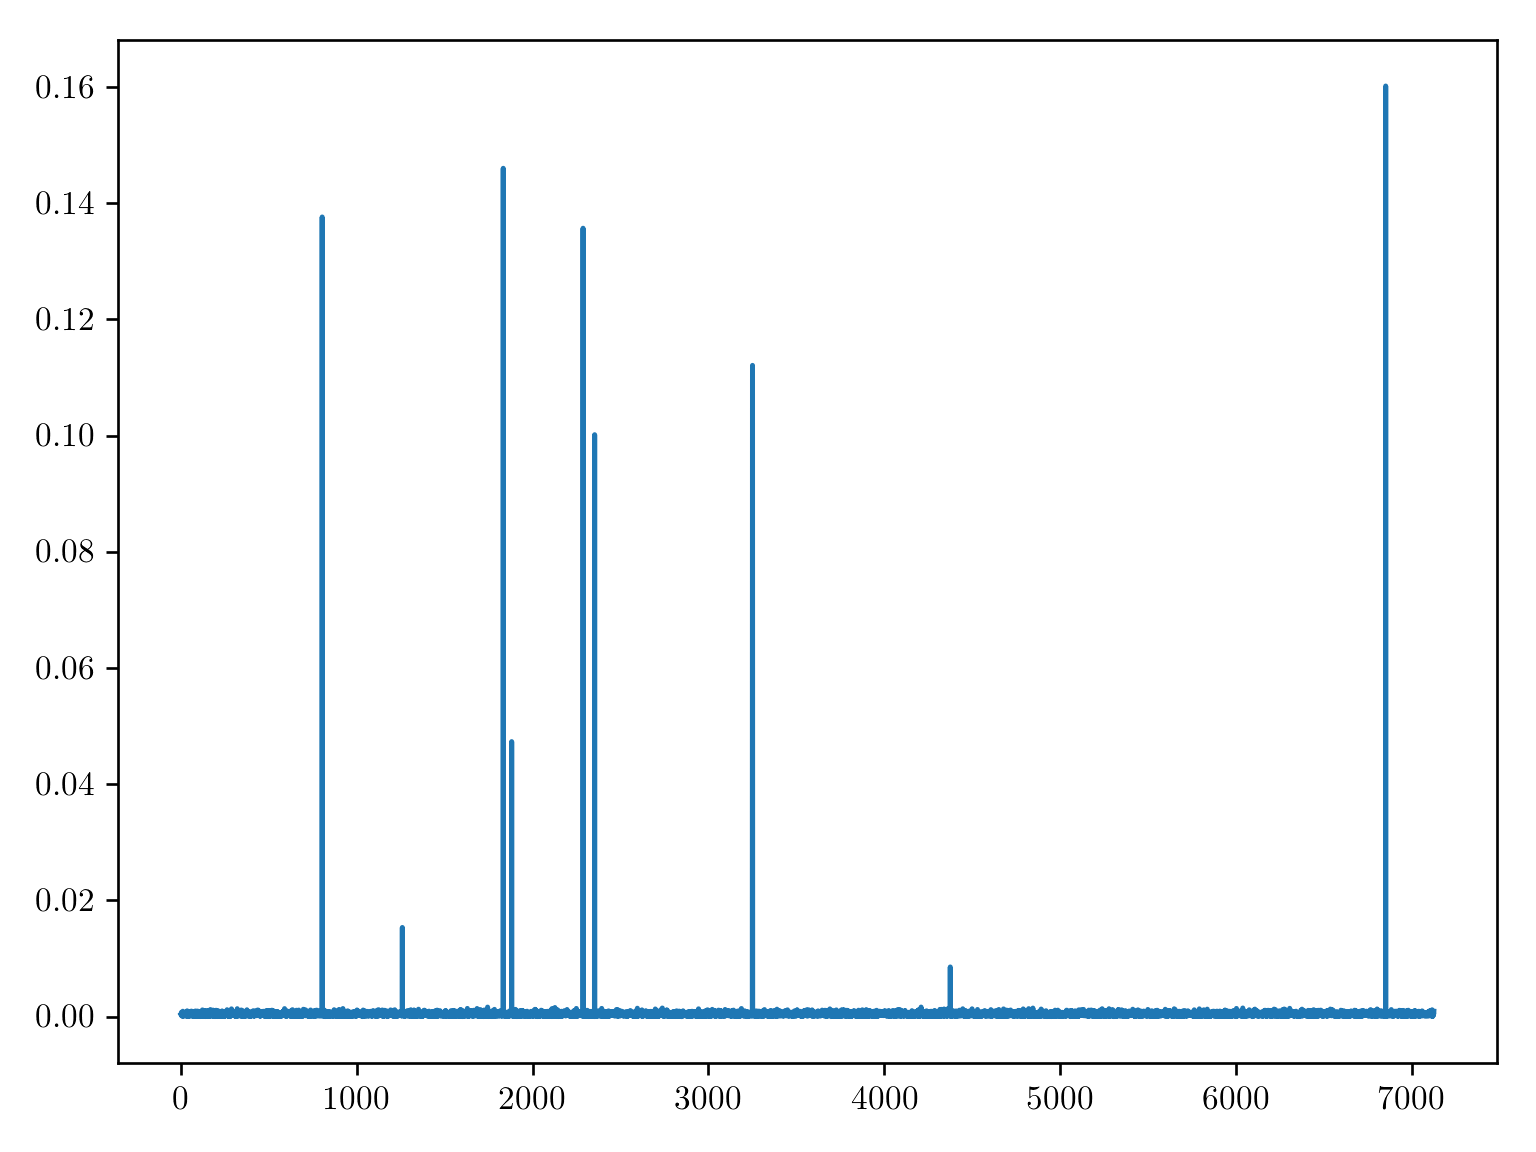

In [218]:
# plot best weights from cross-validated run
import matplotlib.pyplot as plt
plt.plot(np.abs(mylib2.best_weights[1:]))
plt.show()